In [139]:
! pip install eli5

     |████████████████████████████████| 112kB 875kB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/c5/10/369f50bcd4621b263927b0a1519987a04383d4a98fb10438042ad410cf88/singledispatch-3.4.0.3-py2.py3-none-any.whl
     |████████████████████████████████| 51kB 1.1MB/s eta 0:00:011
  Created wheel for tabulate: filename=tabulate-0.8.6-cp35-none-any.whl size=23274 sha256=bbcfdd10b34e25dc7cf42f98d0811e3e08172b04c30eb335025615ef0069603b
  Stored in directory: /home/noomkcalb/.cache/pip/wheels/9c/9b/f4/eb243fdb89676ec00588e8c54bb54360724c06e7fafe95278e
Successfully built tabulate
You should consider upgrading via the 'pip install --upgrade pip' command.


Dataset from https://www.physionet.org/content/eegmmidb/1.0.0/

In [1]:
import pandas as pd

In [2]:
import mne

In [3]:
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from pylab import rcParams

In [6]:
from tqdm import tqdm_notebook

In [7]:
import eli5

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [9]:
from scipy.signal import periodogram

In [10]:
from scipy.stats import mannwhitneyu

In [11]:
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.viz.utils import center_cmap

# Simple and stupid

In [12]:
def get_fourier_transform(data):
    global window_size, step_size
    frequencies = []
    for window in tqdm_notebook(range(0, data.shape[0] - window_size, step_size)):
        chunk = data[window:window + window_size]
        frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
#         _, frequency_values = periodogram(chunk, window_size, axis=0)
        frequencies.append(frequency_values)
    return np.vstack(frequencies)

def get_relative_power(frequencies, main_events):
    baseline = None
    relative_values = []

    for index, (start, _, event) in enumerate(main_events):
        if (index + 1) == main_events.shape[0]:
            end = frequencies.shape[0] * step_size
        else:
            end, _, _ = main_events[index + 1]
            
        if event == 1:
            baseline = frequencies[(start // step_size):(end // step_size)].mean(axis=0)
        
        for power_index in range(start // step_size, end // step_size):
            relative_values += [(frequencies[power_index, :] - baseline) / (baseline)]
        
    return np.vstack(relative_values)    

In [13]:
all_events = {}
for subject in tqdm_notebook(range(5, 100)):
    for task in [4, 8, 12]:

        events_path = "./filtered/S{0:03d}R{1:02d}.edf".format(subject, task)
        baseline_path = "./filtered/S{0:03d}R{1:02d}.edf".format(subject, 1)

        # events_path = "./full-data/eegmmidb-1.0.0.physionet.org/S{0:03d}/S{0:03d}R{1:02d}.edf".format(subject, task)
        # baseline_path = "./full-data/eegmmidb-1.0.0.physionet.org/S{0:03d}/S{0:03d}R{1:02d}.edf".format(subject, 1)

        events_eeg = mne.io.read_raw_fif(
            events_path,
            preload=True
        )
        
        picks = mne.pick_channels(events_eeg.info["ch_names"], ["C3", "Cz", "C4"])

        main_events, _ = mne.events_from_annotations(events_eeg)

        data, times = events_eeg[:]
        channels_data = data[picks, :]

        window_size = (times < 1).sum()
        step_size = window_size // 16

        channel_frequencies = [get_fourier_transform(channel) for channel in channels_data]

        channel_relative_values = [get_relative_power(frequencies, main_events) for frequencies in channel_frequencies]

        for index, (start, _, event) in enumerate(main_events):
            start = start // step_size
            if (index + 1) == main_events.shape[0]:
                end = channel_frequencies[0].shape[0]
            else:
                end, _, _ = main_events[index + 1] // step_size
            windows = [relative_values[start - 16:end] for relative_values in channel_relative_values] # Here is the beginning of the window
            if event not in all_events:
                all_events[event] = []
            all_events[event] += [windows]

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Opening raw data file ./filtered/S005R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S005R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True
/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Opening raw data file ./filtered/S005R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S005R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S005R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S005R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S006R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S006R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S006R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S006R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S006R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S006R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S007R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S007R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S007R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S007R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S007R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S007R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S008R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S008R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S008R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S008R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S008R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S008R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S009R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S009R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S009R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S009R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S009R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S009R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S010R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S010R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S010R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S010R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S010R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S010R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S011R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S011R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S011R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S011R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S011R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S011R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S012R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S012R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S012R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S012R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S012R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S012R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S013R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S013R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S013R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S013R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S013R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S013R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S014R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S014R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S014R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S014R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S014R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S014R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S015R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S015R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S015R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S015R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S015R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S015R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S016R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S016R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S016R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S016R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S016R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S016R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S017R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S017R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S017R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S017R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S017R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S017R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S018R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S018R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S018R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S018R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S018R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S018R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S019R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S019R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S019R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S019R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S019R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S019R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S020R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S020R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S020R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S020R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S020R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S020R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S021R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S021R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S021R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S021R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S021R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S021R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S022R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S022R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S022R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S022R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S022R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S022R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S023R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S023R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S023R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S023R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S023R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S023R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S024R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S024R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S024R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S024R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S024R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S024R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S025R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S025R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S025R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S025R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S025R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S025R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S026R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S026R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S026R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S026R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S026R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S026R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S027R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S027R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S027R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S027R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S027R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S027R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S028R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S028R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S028R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S028R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S028R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S028R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S029R04.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S029R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S029R08.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S029R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S029R12.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S029R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S030R04.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S030R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S030R08.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S030R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S030R12.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S030R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S031R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S031R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S031R08.edf...


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S031R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True


Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']



Opening raw data file ./filtered/S031R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S031R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S032R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S032R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S032R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S032R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S032R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S032R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S033R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S033R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S033R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S033R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S033R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S033R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S034R04.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S034R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S034R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S034R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S034R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S034R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S035R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S035R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S035R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S035R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S035R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S035R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S036R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S036R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S036R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S036R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S036R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S036R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S037R04.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S037R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S037R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S037R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S037R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S037R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S038R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S038R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S038R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S038R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S038R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S038R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S039R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S039R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S039R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S039R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S039R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S039R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S040R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S040R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S040R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S040R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S040R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S040R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S041R04.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S041R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S041R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S041R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S041R12.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S041R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S042R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S042R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S042R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S042R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S042R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S042R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S043R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S043R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S043R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S043R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S043R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S043R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S044R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S044R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S044R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S044R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S044R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S044R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S045R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S045R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S045R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S045R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S045R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S045R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S046R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S046R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S046R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S046R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S046R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S046R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S047R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S047R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S047R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S047R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S047R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S047R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S048R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S048R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S048R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S048R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S048R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S048R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S049R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S049R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S049R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S049R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S049R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S049R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S050R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S050R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S050R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S050R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S050R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S050R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S051R04.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S051R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S051R08.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S051R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S051R12.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S051R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S052R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S052R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S052R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S052R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S052R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S052R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S053R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S053R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S053R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S053R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S053R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S053R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S054R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S054R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S054R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S054R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S054R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S054R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S055R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S055R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S055R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S055R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S055R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S055R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S056R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S056R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S056R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S056R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S056R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S056R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S057R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S057R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S057R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S057R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S057R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S057R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S058R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S058R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S058R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S058R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S058R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S058R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S059R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S059R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S059R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S059R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S059R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S059R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S060R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S060R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S060R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S060R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S060R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S060R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S061R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S061R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S061R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S061R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S061R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S061R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S062R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S062R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S062R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S062R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S062R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S062R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S063R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S063R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S063R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S063R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S063R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S063R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S064R04.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S064R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S064R08.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S064R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S064R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S064R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S065R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S065R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S065R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S065R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S065R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S065R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S066R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S066R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S066R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S066R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S066R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S066R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S067R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S067R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S067R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S067R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S067R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S067R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S068R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S068R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S068R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S068R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S068R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S068R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S069R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S069R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S069R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S069R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S069R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S069R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S070R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S070R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S070R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S070R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S070R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S070R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S071R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S071R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S071R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S071R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S071R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S071R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S072R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S072R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S072R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S072R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S072R12.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S072R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S073R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S073R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S073R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S073R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S073R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S073R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S074R04.edf...
Isotrak not found
    Range : 0 ... 19839 =      0.000 ...   123.994 secs
Ready.
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S074R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S074R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S074R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S074R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S074R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S075R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S075R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S075R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S075R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S075R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S075R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S076R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S076R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S076R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S076R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S076R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S076R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S077R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S077R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S077R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S077R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S077R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S077R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S078R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S078R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S078R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S078R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S078R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S078R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S079R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S079R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S079R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S079R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S079R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S079R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S080R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S080R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S080R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S080R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S080R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S080R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S081R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S081R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S081R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S081R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S081R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S081R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S082R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S082R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S082R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S082R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S082R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S082R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S083R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S083R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S083R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S083R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S083R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S083R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S084R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S084R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S084R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S084R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S084R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S084R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S085R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S085R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S085R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S085R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S085R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S085R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S086R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S086R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S086R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S086R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S086R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S086R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S087R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S087R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S087R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S087R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S087R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S087R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S088R04.edf...
Isotrak not found
    Range : 0 ... 15871 =      0.000 ...   123.992 secs
Ready.
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S088R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S088R08.edf...
Isotrak not found
    Range : 0 ... 15871 =      0.000 ...   123.992 secs
Ready.
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S088R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S088R12.edf...
Isotrak not found
    Range : 0 ... 15871 =      0.000 ...   123.992 secs
Ready.
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S088R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S089R04.edf...


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S089R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True


Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']



Opening raw data file ./filtered/S089R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S089R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S089R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S089R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S090R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S090R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S090R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S090R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S090R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S090R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S091R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S091R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S091R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S091R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S091R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S091R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S092R04.edf...
Isotrak not found
    Range : 0 ... 15871 =      0.000 ...   123.992 secs
Ready.
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S092R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S092R08.edf...
Isotrak not found
    Range : 0 ... 15871 =      0.000 ...   123.992 secs
Ready.
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S092R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S092R12.edf...
Isotrak not found
    Range : 0 ... 15871 =      0.000 ...   123.992 secs
Ready.
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S092R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S093R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S093R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S093R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S093R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S093R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S093R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S094R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S094R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S094R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S094R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S094R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S094R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S095R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S095R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S095R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S095R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S095R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S095R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S096R04.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S096R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S096R08.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S096R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S096R12.edf...
Isotrak not found
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S096R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S097R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S097R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S097R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S097R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S097R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S097R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S098R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S098R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S098R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S098R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S098R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S098R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True



Opening raw data file ./filtered/S099R04.edf...


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S099R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True


Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2', 'T1', 'T0']



Opening raw data file ./filtered/S099R08.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S099R08.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True


Used Annotations descriptions: ['T2', 'T1', 'T0']



Opening raw data file ./filtered/S099R12.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


<ipython-input-13-6f163847b9a9>:13: RuntimeWarning: This filename (./filtered/S099R12.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True


Used Annotations descriptions: ['T2', 'T1', 'T0']


In [14]:
min_possible_shape = 80

In [15]:
min_shape = min(
    min([w[0].shape[0] for w in all_events[1] if w[0].shape[0] > min_possible_shape]), 
    min([w[0].shape[0] for w in all_events[2] if w[0].shape[0] > min_possible_shape]), 
    min([w[0].shape[0] for w in all_events[3] if w[0].shape[0] > min_possible_shape])
)

In [16]:
min_shape

81

# Signal processing

In [17]:
def prepare_signal(windows, min_shape):
    normalized_windows = [np.vstack([
        window[:, 8:13].mean(axis=1)[:min_shape],
        np.ones(min_shape)
    ]).min(axis=0) for window in windows]
    return np.hstack(normalized_windows)

In [18]:
all_signals = {}

for event, windows in all_events.items():
    all_signals[event] = []
    for window in windows:
        if len(window[0]) < min_shape:
            continue
        all_signals[event] += [prepare_signal(window, min_shape)]

# Simple classification

In [19]:
signal_features = []
signal_types = []
for event, signals in all_signals.items():
    for signal in signals:
        signal_features += [signal]
        signal_types += [event - 1]

In [20]:
signal_features = np.vstack(signal_features)

In [21]:
signal_types = np.array(signal_types)

In [22]:
X = signal_features
y = signal_types != 0

In [23]:
signal_features_df = pd.DataFrame(signal_features)

In [24]:
# plt.plot(signal_features[signal_types == 2][0:100].T, color="blue")
# plt.plot(signal_features[signal_types == 1][0:100].T, color="blue")
# # plt.plot(signal_features[signal_types == 3][0:10].T, color="blue")
# plt.plot(signal_features[signal_types == 0][0:100].T, color="red")
# plt.show()

In [25]:
grid = {
#     "C": np.linspace(0.1, 10, 100)
    "n_estimators": [500]
}
model = GradientBoostingClassifier()
search = GridSearchCV(model, grid, scoring="roc_auc", cv=5, verbose=True, n_jobs=3)
search.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  8.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [26]:
search.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [27]:
search.best_score_

0.9451766256086864

In [28]:
explanation = eli5.explain_weights(search.best_estimator_)

In [29]:
# plt.plot(smooth_path, linewidth=2) #mean curve.
# plt.fill_between(path_deviation.index, under_line, over_line, color='b', alpha=.1)

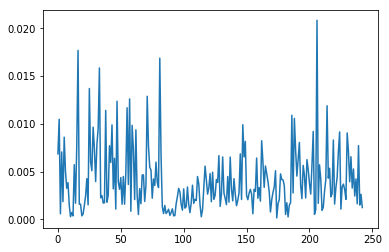

In [30]:
plt.plot(search.best_estimator_.feature_importances_)

# Real-time approval

In [31]:
subject = 2
task = 4

In [32]:
events_path = "./filtered/S{0:03d}R{1:02d}.edf".format(subject, task)

In [33]:
events_eeg = mne.io.read_raw_fif(
    events_path,
    preload=True
)

Opening raw data file ./filtered/S002R04.edf...
Isotrak not found
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


<ipython-input-33-a0d46778d20a>:3: RuntimeWarning: This filename (./filtered/S002R04.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  preload=True


In [34]:
picks = mne.pick_channels(events_eeg.info["ch_names"], ["C3", "Cz", "C4"])

In [35]:
main_events, _ = mne.events_from_annotations(events_eeg)

Used Annotations descriptions: ['T2', 'T1', 'T0']


In [36]:
data, times = events_eeg[:]
channels_data = data[picks, :]

In [37]:
window_size = (times < 1).sum()
step_size = window_size // 16

In [38]:
frequencies_chunk_size = min_shape
chunk_size = min_shape * 15 # depends on model

In [39]:
def chunk_get_fourier_transform(data, window_size, step_size):
    frequencies = []
    for window in range(0, data.shape[0] - window_size, step_size):
        chunk = data[window:window + window_size]
        frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
        frequencies.append(frequency_values)
    return np.vstack(frequencies)

def chunk_get_relative_power(frequencies, baseline):
    relative_values = []

    for power_index in range(0, frequencies.shape[0]):
        relative_values += [(frequencies[power_index, :] - baseline) / baseline]
    return np.vstack(relative_values)

In [40]:
movement_model = search.best_estimator_

In [41]:
main_events_start = [s for s, _, t in main_events if t != 1]
main_events_end = [e for e, _, t in main_events if t == 1][1:]
main_events_time = list(zip(main_events_start, main_events_end))

In [42]:
baseline_threshold = 0.5
event_threshold = 0.5

In [43]:
metrics = []

for baseline_threshold in tqdm_notebook(np.linspace(0.1, 0.999, 30)):
    for event_threshold in np.linspace(0.1, 0.999, 30):
        channel_baseline = None
        channel_chunk = None
        possible_events = []
        baseline_events = []

        for i in range(0, channels_data[0].shape[0], window_size):
            # Concat new window
            new_window = channels_data[:, i:i + window_size]
            if channel_chunk is None:
                channel_chunk = list(new_window)
            else:
                # TODO check dim - (channels, timestamps)
                channel_chunk = [
                    np.hstack([chunk, window])[-chunk_size:] 
                    for chunk, window in zip(channel_chunk, new_window)
                ]

            if channel_chunk[0].shape[0] < chunk_size:
                continue

            channel_frequencies = [chunk_get_fourier_transform(chunk, window_size, step_size)[:frequencies_chunk_size] for chunk in channel_chunk]

            if channel_baseline is None:
                channel_baseline = [frequencies.mean(axis=0) for frequencies in channel_frequencies]
            else:
                relative_values = [
                    chunk_get_relative_power(frequencies, baseline) 
                    for frequencies, baseline in zip(channel_frequencies, channel_baseline)
                ]
                processed_signal = prepare_signal(relative_values, frequencies_chunk_size)
                baseline_probability, event_probability = movement_model.predict_proba([processed_signal])[0]
        #         print(baseline_probability)
                if baseline_probability > baseline_threshold:
                    channel_baseline = [frequencies.mean(axis=0) for frequencies in channel_frequencies]
                    baseline_events.append(i - chunk_size)
                elif event_probability > event_threshold:
                    possible_events.append(i - chunk_size)

        if len(possible_events):
            mapping = {}
            for t in possible_events:
                for a, b in main_events_time:
                    if (t > a - window_size) & (t < b + window_size):
                        mapping[t] = a
            precision = len(set(mapping.keys())) / len(possible_events)
            recall = len(set(mapping.values())) / len(main_events_time)
            f1 = 2 * precision * recall / (precision + recall + 0.000001)
            metrics.append([baseline_threshold, event_threshold, precision, recall, f1])

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
metrics_df = pd.DataFrame(metrics, columns=["baseline_threshold", "event_threshold", "precision", "recall", "f1"])

Хотим, чтобы ивент триггерился не на все события, но как можно точнее - precision

In [45]:
metrics_df[metrics_df["recall"] >= 0.5].sort_values("precision", ascending=False).iloc[0:30]

,baseline_threshold,event_threshold,precision,recall,f1
717,0.813,0.968,0.880000,0.642857,0.742964
747,0.844,0.968,0.880000,0.642857,0.742964
716,0.813,0.937,0.870968,0.785714,0.826147
746,0.844,0.937,0.870968,0.785714,0.826147
835,0.937,0.906,0.854545,1.000000,0.921568
836,0.937,0.937,0.851064,0.928571,0.888129
864,0.968,0.875,0.851064,1.000000,0.919540
893,0.999,0.875,0.847826,1.000000,0.917647
896,0.999,0.968,0.842105,0.642857,0.729113
57,0.131,0.937,0.842105,0.500000,0.627451


# Statistical test

In [189]:
p_value_map = np.zeros((min_shape, frequencies_shape))

for i in range(min_shape):
    for j in range(frequencies_shape):
        a = np.hstack([w[i*cell_size:(i + 1)*cell_size, j:j+1].reshape(-1) for w in all_events[1] if w.shape[0] > 0])
        b = np.hstack([w[i*cell_size:(i + 1)*cell_size, j:j+1].reshape(-1) for w in all_events[2]])
        p_value_map[i, j] = mannwhitneyu(a, b).pvalue

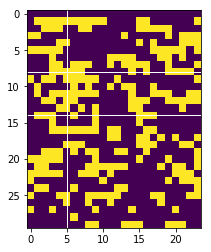

In [192]:
plt.imshow(p_value_map.T < 0.05)
plt.axhline(8, color="white", linewidth=1)
plt.axhline(14, color="white", linewidth=1)
plt.axvline(16 // cell_size, color="white", linewidth=1)